# HW4 

### Tyler Klimas

In [ ]:
# !pip install transformers datasets
# !pip install torch

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from datasets import load_dataset
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AdamW
from torch.utils.data import DataLoader
from transformers import BertTokenizer

/opt/anaconda3/envs/compsci371/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Import the Dataset, and create training and testing splits. Here I am only using 5% of the entire corpus for each respective training and testing, as the original dataset contains 560,000 samples, and I choose to work with 28,000 (My computer is not that powerful!)
### In order to scale this to a very large K, vertical scaling (Powerful GPU) or horizontal scaling (Distributed Training) can be employed while batching the data as large as possible to fit on a GPU is how this would be done.
### I am using BertTokenizer from huggingface, which breaks the corpus of text into words and subwords, and maps them to corresponding numerical IDs.
### I reveal that the vocab size is 30,522

In [6]:
sentiment = load_dataset("yelp_polarity")
tr = sentiment['train']
print(f"Original training set size: {len(tr)}")
ts = sentiment['test']
tr = tr.train_test_split(test_size=0.95)['train']
print(f"Smaller training set size (5% of original): {len(tr)}")
ts = ts.train_test_split(test_size=0.95)['train']


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_function(data):
    return tokenizer(data['text'], padding='max_length', truncation=True)

tokenized_dataset = tr.map(tokenize_function, batched=True)

word_count = tokenizer.vocab_size
print("Vocab Size:", word_count)

Original training set size: 560000
Smaller training set size (5% of original): 28000


Map: 100%|████████████████████████| 28000/28000 [00:51<00:00, 545.05 examples/s]

Vocab Size: 30522


### Example of what the tokenizer returns

In [7]:
tokenizer("NLP is fun!")

{'input_ids': [101, 17953, 2361, 2003, 4569, 999, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}

### Here I load the datasets into DataLoader objects which make it possible to batch the data in the training phase.

In [8]:
batch_size = 8

tr = tr.map(tokenize_function, batched=True)
tr.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
tr_loader = DataLoader(tr, batch_size=batch_size, shuffle=True)

ts = ts.map(tokenize_function, batched=True)
ts.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
ts_loader = DataLoader(ts, batch_size=batch_size, shuffle=False)

Map: 100%|██████████████████████████| 1900/1900 [00:03<00:00, 539.21 examples/s]


### This is our model, which uses a word embedding layer to represent each word in a 10 dimensional vector, and then is averaged together across all embeddings in the sentence to form a single vector. Finally the vector is fed forward into a fully connected layer which outputs one logit, representing Positive or Negative sentiment.

In [9]:
class LinearRegression(nn.Module):
    def __init__(self, word_count, embedding_dim):
        super(LinearRegression, self).__init__()
        self.embed_words = nn.Embedding(word_count, embedding_dim)  
        self.layer1 = nn.Linear(embedding_dim, 1)

    def forward(self, x):
        embedded = self.embed_words(x) 
        avg_embedding = embedded.mean(dim=1) 
        out = self.layer1(avg_embedding) 
        return out  

In [10]:
embedding_dim = 10 

### Using Adam, our gradient descent converges much faster as each parameters gradient is updated dynamically. Binary Cross Entropy Loss is a suitable loss function for binary classification as it computes the Sigmoid non-linearity internally

In [11]:
model = LinearRegression(word_count, embedding_dim)
stepper = optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.BCEWithLogitsLoss()

### This is the function which trains the model, for each epoch, it trains on a batch of data (8 in this case) by setting the gradient to 0, getting the outputs from the function, calculating the loss, backpropogating, and then adjusting the weights against the gradient.


### Cost Function

$$
\mathcal{J}(\mathbf{W}, b) = \frac{1}{N} \sum_{i=1}^{N} \left( \log(1 + e^{z^{(i)}}) - y^{(i)} z^{(i)} \right)
$$

### Logit

$$
z^{(i)} = \mathbf{W} \cdot \mathbf{x}^{(i)} + b
$$

### Gradient of Loss w.r.t Logit \( z \)

$$
\frac{\partial \mathcal{L}(y, z)}{\partial z} = \sigma(z) - y
$$


$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

### Gradient of Cost Function w.r.t Weights \( \mathbf{W} \)

$$
\frac{\partial \mathcal{J}}{\partial \mathbf{W}} = \frac{1}{N} \sum_{i=1}^{N} \left( \sigma(z^{(i)}) - y^{(i)} \right) \mathbf{x}^{(i)}
$$

### Gradient of Cost Function w.r.t Bias \( b \)

$$
\frac{\partial \mathcal{J}}{\partial b} = \frac{1}{N} \sum_{i=1}^{N} \left( \sigma(z^{(i)}) - y^{(i)} \right)
$$


In [19]:
def forward_pass(model, dataloader, stepper, loss_function, iterations=10):
    model.train()
    for e in range(iterations):
        total_loss = 0
        for sample in dataloader:
            stepper.zero_grad()
            outputs = model(sample['input_ids']).squeeze()
            loss = loss_function(outputs, sample['label'].float())
            loss.backward()
            stepper.step()
            total_loss = total_loss + loss.item()
        
        print('Epoch:', e, "Loss:", total_loss/len(dataloader))

### After 10 epochs, the loss function is stabilizing and returning decent scores.

In [13]:
forward_pass(model, tr_loader, stepper, loss_function, 10)

Epoch: 0 Loss: 0.6610657504371235
Epoch: 1 Loss: 0.5467668408879212
Epoch: 2 Loss: 0.4331878859826497
Epoch: 3 Loss: 0.358958236616637
Epoch: 4 Loss: 0.3104096944667399
Epoch: 5 Loss: 0.2774354569560715
Epoch: 6 Loss: 0.25361801139744267
Epoch: 7 Loss: 0.23587282697537115
Epoch: 8 Loss: 0.22162704635278455
Epoch: 9 Loss: 0.20961055909017368


### Testing the model after training

In [16]:
import numpy as np

def test_model(model, dataloader):
    model.eval()
    accurate = 0
    amt = 0
    
    with torch.no_grad():
        for sample in dataloader:
            outputs = model(sample['input_ids']).squeeze()
            predicted = (outputs > 0.5).float()
            accurate += (predicted == sample['label']).sum().item()
            amt += sample['label'].size(0)
    
    
    print("Amount Correct:", np.round((accurate / amt) * 100, 2), '%')

### 90% accuracy

In [17]:
test_model(model, ts_loader)

Amount Correct: 90.16 %


### This is a histogram of all the embeddings learned. As you can see, the majority of words fall around the origin, with only a few words having large absolute values. The words near 0 have little influence on the model (is, are, a, etc.) and the words with large embeddings have magnitude that indicate the strength or importance of the feature.

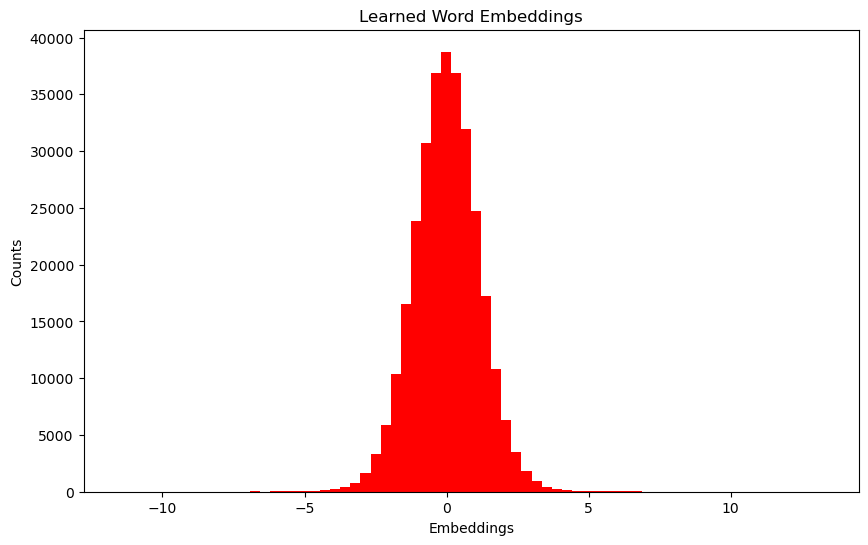

In [18]:
import matplotlib.pyplot as plt


embeddings = model.embed_words.weight.data
plt.figure(figsize=(10, 6))
plt.hist(embeddings.flatten(), bins=70, color='red')
plt.title("Learned Word Embeddings")
plt.xlabel("Embeddings")
plt.ylabel("Counts")
plt.show()

### We can see clearly the words with the largest magnitude are going to be the words which make the review positive or negative. We are averaging the entirety of the word vectors for each sentence, so one of these words will influence the models final output.

In [24]:
embeddings = model.embed_words.weight.data
abs_embeddings = embeddings.abs()
word_scores = abs_embeddings.sum(dim=1)
top_n = 20
top_indices = torch.topk(word_scores, top_n).indices

for idx in top_indices:
    print(f"{tokenizer.convert_ids_to_tokens([idx.item()])}, Value: {word_scores[idx].item()}")

['worst'], Value: 109.76428985595703
['horrible'], Value: 99.1498794555664
['terrible'], Value: 92.29383850097656
['great'], Value: 90.35585021972656
['delicious'], Value: 89.29381561279297
['amazing'], Value: 85.99119567871094
['awesome'], Value: 85.5875015258789
['excellent'], Value: 82.70612335205078
['bland'], Value: 81.29125213623047
['rude'], Value: 78.89187622070312
['awful'], Value: 73.00436401367188
['perfect'], Value: 69.47359466552734
['loved'], Value: 69.26802825927734
['##cre'], Value: 67.69816589355469
['best'], Value: 65.74842834472656
['fantastic'], Value: 65.7218017578125
['definitely'], Value: 64.94883728027344
['gross'], Value: 64.86540222167969
['poor'], Value: 64.17562103271484
['ok'], Value: 63.89420700073242


# This was my attempt to use pretrained models from huggingface rather than my own PyTorch model, to no avail

In [2]:
sentiment = load_dataset("yelp_polarity")
tr = sentiment['train']
ts = sentiment['test']
tr = tr.train_test_split(test_size=0.97)['train']
ts = ts.train_test_split(test_size=0.97)['train']

In [3]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

/opt/anaconda3/envs/compsci371/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
batch_size = 8
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
def tokenize_function(batch):
    return tokenizer(batch['text'], padding=True, truncation=True, max_length=512, return_tensors="pt")

In [6]:
tr = tr.map(tokenize_function, batched=True)
tr.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

Map: 100%|███████████████████████| 16800/16800 [00:08<00:00, 1869.18 examples/s]


In [7]:
train_loader = DataLoader(tr, batch_size=batch_size, shuffle=True)

In [8]:
ts = ts.map(tokenize_function, batched=True)
ts.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
ts_loader = DataLoader(ts, batch_size=batch_size, shuffle=False)

Map: 100%|█████████████████████████| 1140/1140 [00:00<00:00, 1930.57 examples/s]


In [10]:
optimizer = AdamW(model.parameters(), lr=2e-2)

/opt/anaconda3/envs/compsci371/lib/python3.12/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
for epoch in range(1): 
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}")